## Importing modules

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import math
from sklearn.model_selection import GridSearchCV
import time
import matplotlib.pyplot as plt

## Loading the dataset

In [2]:
# Load the data
df = pd.read_csv('../datasets/complete_data/df.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 37 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   start MTU (UTC)                                                                8760 non-null   object 
 1   Day-ahead Price [EUR/MWh] BZN|NO1                                              8760 non-null   float64
 2   Day-ahead Price [EUR/MWh] BZN|NO3                                              8760 non-null   float64
 3   Day-ahead Price [EUR/MWh] BZN|NO5                                              8760 non-null   float64
 4   Day-ahead Price [EUR/MWh] BZN|SE3                                              8760 non-null   float64
 5   Actual Total Load [MW] - BZN|NO5                                               8760 non-null   float64
 6   Hydro Run-of-river and p

The datatype of the datetime column "start MTU (UTC)" is object, so we need to convert it into a datetime object. We then need to set the "start MTU (UTC)" column as the index, which is required for time series analysis.

In [4]:
# Convert the date column to datetime
df['start MTU (UTC)'] = pd.to_datetime(df['start MTU (UTC)'])

# Set the date column as the index
df.set_index('start MTU (UTC)', inplace=True)


## Splitting the data

In [5]:
# Split the data into training and test sets
# shuffle is set to false so that the ordinality of the data is maintained
train, test = train_test_split(df, test_size=0.2, shuffle=False)

## Creating a lagged dataset with 24 lag features for each input feature

### NB! this is direct copy, needs to be rewritten!
When we want to make time series predictions, we need to consider the temporal relationship between the observations. In other words, we need to take into account the fact that each observation is measured at a particular time and that the observations over time are not independent of each other. Therefore, we can't simply use all of the data to train our model, as we would in a typical machine learning problem.

Instead, we typically create a "lagged" dataset where each row contains the predictors and the target variable for a particular time step. We use this lagged dataset to train our model. To create this lagged dataset, we shift the target variable forward by one or more time steps and use the resulting series as the target variable for that time step. We also include the values of the predictors at the previous time steps as features. This way, the model can learn to use the past values of the predictors to predict the future value of the target variable.

In the case of hourly data and a prediction horizon of 24 hours, we would create a lagged dataset where each row contains the predictors and the target variable for a particular hour. The target variable for each row would be the value 24 hours in the future, and the predictors for each row would be the values of the predictors for the previous 24 hours. We would then use this lagged dataset to train our model to make predictions for the next 24 hours.

By shifting the target feature forward by one period, we are effectively creating a dataset where each observation includes the past observations up to the previous period and the target variable value for the next period.

In [6]:
# Function to create lagged dataset wit 24 lag features for each input feature
def create_lagged_dataset(df):
    # creating a copy of the dataframe
    lagged_df = df.copy()
    
    # Adding lagged features for target variable
    lagged_df['Day-ahead Price [EUR/MWh] BZN|NO1'] = lagged_df['Day-ahead Price [EUR/MWh] BZN|NO1'].shift(-1)
    
    # Dropping the last row containing NaN values
    lagged_df.dropna(inplace=True)
    
    # Creating a dataframe with lagged features with 24 steps for each of the original features
    lagged_df = pd.concat([lagged_df.shift(i) for i in range(24)], axis=1)
    
    # Removing the NaN rows that have been created in the beginning of the dataset
    lagged_df.dropna(inplace=True)
    
    return lagged_df

In [7]:
# creating lagged dataset for train and test dataset
lagged_train = create_lagged_dataset(train)
lagged_test = create_lagged_dataset(test)

In [1]:
# separating the target feature and the input features
train_y = lagged_train['Day-ahead Price [EUR/MWh] BZN|NO1']
train_x = lagged_train.drop(['Day-ahead Price [EUR/MWh] BZN|NO1'], axis=1)

test_y = lagged_test['Day-ahead Price [EUR/MWh] BZN|NO1']
test_x = lagged_test.drop(['Day-ahead Price [EUR/MWh] BZN|NO1'], axis=1)

NameError: name 'lagged_train' is not defined

## Training the models

In [9]:
# start timer
start_time = time.time()

# Create a random forest regressor
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Fit the model on the training data
model.fit(train_x, train_y)

# Make predictions on the test data
pred_y = model.predict(test_x)

# stop timer
end_time = time.time()
#print the run time
print("Runtime: {:.2f} seconds".format(end_time - start_time))

# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(test_y, pred_y)
print("Mean absolute error:            ", mae)

# Calculate the mean absolute percentage error (MAE) between the predicted and actual values
mape = mean_absolute_percentage_error(test_y, pred_y)
print("Mean absolute percentage error: ", mape)

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(test_y, pred_y)
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Rood mean squared error:        ", rmse)

Runtime: 551.90 seconds
Mean absolute error:             18.795299940865252
Mean absolute percentage error:  4.020068049004947
Mean squared error:              714.3661524637204
Rood mean squared error:         26.727629009392516


## Plotting predicted vs actual values for the base model:

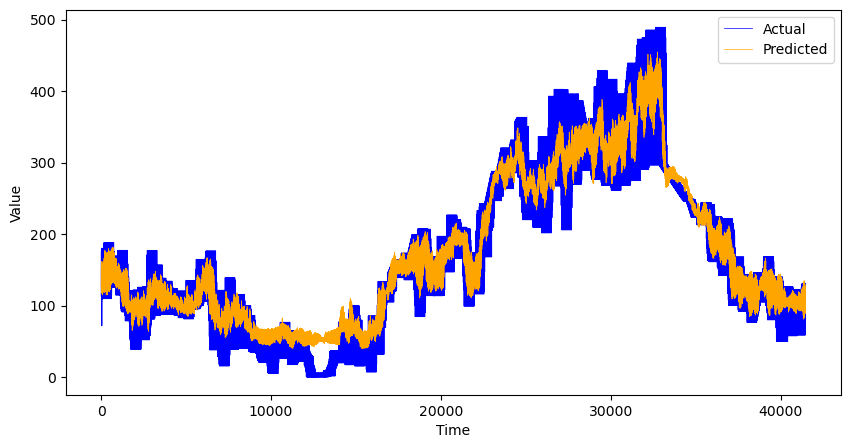

In [26]:
# create a DataFrame with the actual and predicted values
results = pd.DataFrame({'Actual': test_y, 'Predicted': pred_y})

# create a line chart with different colors for actual and predicted values
plt.figure(figsize=(10, 5))  # set figure size
plt.plot(results.index, results['Actual'], color='blue', linewidth=0.5, label='Actual')
plt.plot(results.index, results['Predicted'], color='orange', linewidth=0.5, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


### NB! this is direct copy, needs to be rewritten!
In terms of MAPE, a commonly used benchmark is a value less than 10%. However, this can vary depending on the specific industry and application. For example, in finance, a MAPE less than 2% may be considered good.

For RMSE, a good value depends on the scale of the data being analyzed. A common practice is to compare the RMSE to the range of the target variable. As a rough guideline, an RMSE that is less than 10% of the range of the target variable can be considered good.

## hyper parameter tuning

When using the RandomForestRegressor from sklearn.ensemble, there are several hyperparameters that can be tuned to improve the performance of the model. Some of the most important hyperparameters are:

n_estimators: The number of decision trees in the random forest. Increasing this parameter can improve the accuracy of the model, but may also increase the training time.

max_depth: The maximum depth of each decision tree in the random forest. Increasing this parameter can allow the model to capture more complex relationships in the data, but may also increase the risk of overfitting.

min_samples_split: The minimum number of samples required to split an internal node in a decision tree. Increasing this parameter can prevent overfitting, but may also decrease the accuracy of the model.

min_samples_leaf: The minimum number of samples required to be at a leaf node in a decision tree. Increasing this parameter can also prevent overfitting, but may result in a simpler model with reduced accuracy.

max_features: The maximum number of features considered for splitting each node in a decision tree. This parameter can affect the randomness of the forest and may impact the accuracy of the model.

bootstrap: Whether or not to bootstrap the samples used for each tree. Setting this parameter to False can decrease the randomness of the forest and may increase the risk of overfitting.

This code uses GridSearchCV to perform a grid search over a range of hyperparameters, with 5-fold cross-validation to evaluate the performance of each combination of hyperparameters. The scoring parameter is set to 'neg_mean_squared_error' to indicate that the model should be optimized to minimize the mean squared error.

In [10]:
# start timer
start_time = time.time()

# Define the hyperparameters to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Create a random forest regressor
model = RandomForestRegressor(random_state=0)

# Create a grid search object
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit the grid search to the training data
grid_search.fit(train_x, train_y)

# stop timer
end_time = time.time()
#print the run time
print("Runtime: {:.2f} seconds".format(end_time - start_time))

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

# Make predictions on the test data using the best model
best_model = grid_search.best_estimator_
pred_y = best_model.predict(test_x)

# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(test_y, pred_y)
print("Mean absolute error:            ", mae)

# Calculate the mean absolute percentage error (MAE) between the predicted and actual values
mape = mean_absolute_percentage_error(test_y, pred_y)
print("Mean absolute percentage error: ", mape)

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(test_y, pred_y)
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Rood mean squared error:        ", rmse)


C:\Users\kjell\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Runtime: 68021.30 seconds
Best hyperparameters:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Mean absolute error:             19.049794130029
Mean absolute percentage error:  4.077765007049325
Mean squared error:              713.5480109212364
Rood mean squared error:         26.712319459778037


## Plotting predicted vs actual values for the best model:

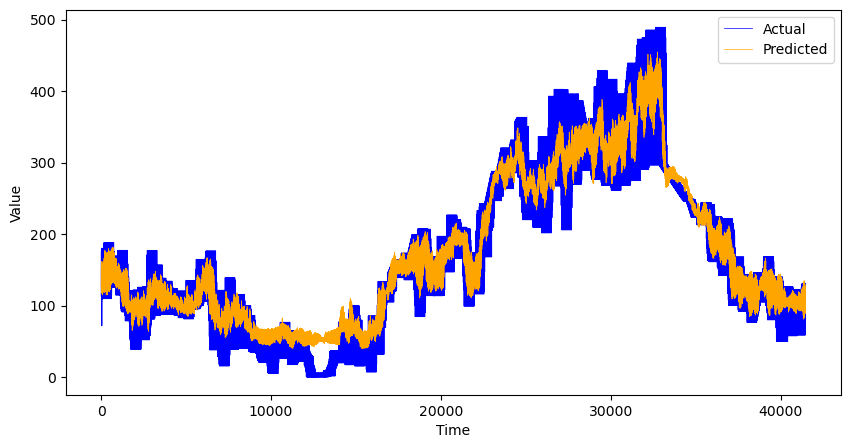

In [35]:

# create a DataFrame with the actual and predicted values
results = pd.DataFrame({'Actual': test_y, 'Predicted': pred_y})

# create a line chart with different colors for actual and predicted values
plt.figure(figsize=(10, 5))  # set figure size
plt.plot(results.index, results['Actual'], color='blue', linewidth=0.5, label='Actual')
plt.plot(results.index, results['Predicted'], color='orange', linewidth=0.5, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()